In [1]:
import os
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import random
from tqdm import tqdm
from subprocess import call
import splitfolders
import tensorflow as tf
import keras
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import segmentation_models_3D as sm

2022-10-29 21:42:12.251386: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
from keras.models import Model, load_model##########################
#This part of the code to get an initial understanding of the dataset.
#################################
#PART 1: Load sample images and visualize
#Includes, dividing each image by its max to scale them to [0,1]
#Converting mask from float to uint8
#Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)
#Visualize
###########################################
#View a few images

#Note: Segmented file name in Folder 355 has a weird name. Rename it to match others.

TRAIN_DATASET_PATH = './BraTS2021_train/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_flair.nii.gz').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_t1.nii.gz').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH +'BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_t2.nii.gz').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00000/BraTS2021_00000_seg.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

2934.0
[0 1 2 4]
[0 1 2 3]


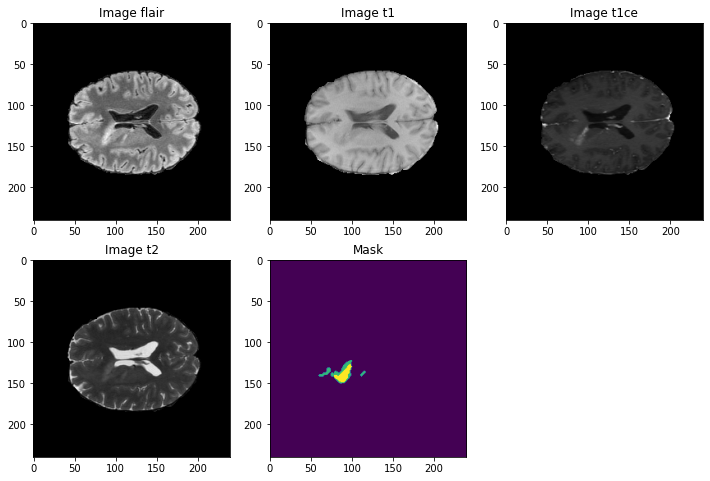

In [5]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [6]:
##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

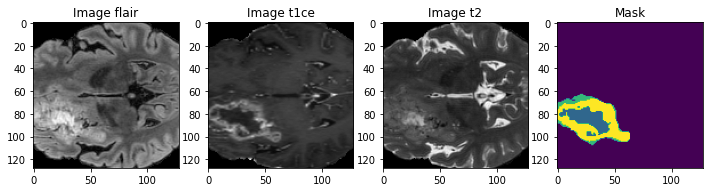

In [7]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(141)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(142)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(143)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(144)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [8]:
imsave('./combined255.tif', combined_x)
np.save('./combined255.npy', combined_x)
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('./combined255.npy')

comparison = combined_x == my_img
equal_arrays = comparison.all()
  
print(equal_arrays)

/tmp/ipykernel_1010794/2183339203.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('./combined255.tif', combined_x)


True


### Generate tumor core and enhancing tumor and corrosponding inputs

In [ ]:
####################################################################
#####################################
#End of understanding the dataset. Now get it organized.
#####################################

#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# # # images lists harley

flair_list = sorted(glob.glob('./BraTS2021_train/*/*flair.nii.gz'))
t1ce_list = sorted(glob.glob('./BraTS2021_train/*/*t1ce.nii.gz'))
t2_list = sorted(glob.glob('./BraTS2021_train/*/*t2.nii.gz'))
t1_list = sorted(glob.glob('./BraTS2021_train/*/*t1.nii.gz'))
mask_list = sorted(glob.glob('./BraTS2021_train/*/*seg.nii.gz'))

#Each volume generates 18 64x64x64x4 sub-volumes.
#Total 369 volumes = 6642 sub volumes
image_path='./data/images'
mask_path='./data/masks'

# Check whether the specified path exists or not
if not os.path.exists(image_path):

    # Create a new directory because it does not exist 
    os.makedirs(image_path)

if not os.path.exists(mask_path):
    os.makedirs(mask_path)

print("Now preparing image and masks number: ")
useless = 0

for img in tqdm(range(len(flair_list))):   #Using t1_list as all lists are of same size
  
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    
    #print(np.unique(temp_mask))
    
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
#         print("Save Me")

        temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
        temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

        temp_image_t2=nib.load(t2_list[img]).get_fdata()
        temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
        
        temp_image_t1=nib.load(t1_list[img]).get_fdata()
        temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
        
        temp_image_flair=nib.load(flair_list[img]).get_fdata()
        temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

        temp_combined_images = np.stack([temp_image_flair, temp_image_t2, temp_image_t1ce, temp_image_t1], axis=3)
        temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
        
        #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
        #cropping x, y, and z
        whole_tumor = temp_mask.copy() 
        whole_tumor[whole_tumor==2] = 1  #Reassign mask values 4 to 3
        whole_tumor[whole_tumor==4] = 1  #Reassign mask values 4 to 3

        mask_1 = np.expand_dims(whole_tumor, axis=-1)
        merged = temp_combined_images*mask_1

        tumor_core = temp_mask.copy()
        tumor_core[tumor_core==2] = 0  #Reassign mask values 4 to 3
        tumor_core[tumor_core==4] = 1  #Reassign mask values 4 to 3
        
        enhancing_tumor = temp_mask.copy()
        enhancing_tumor[enhancing_tumor==1] = 0  #Reassign mask values 4 to 3
        enhancing_tumor[enhancing_tumor==2] = 0  #Reassign mask values 4 to 3
        enhancing_tumor[enhancing_tumor==4] = 1  #Reassign mask values 4 to 3
        
        temp_combined_masks = np.stack([whole_tumor, tumor_core, enhancing_tumor], axis=3)
        
        np.save(image_path + '/image_'+str(img)+'.npy', temp_combined_images)
        np.save(mask_path + '/mask_'+str(img)+'.npy', temp_combined_masks)
        
    else:
        useless+=1
print("Finished")
print("Usefull Images:",len(t2_list)-useless)
print("Useless Images:",useless)

In [ ]:
#Split training data into train and validation

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 
pip install split-folders
"""

input_folder = './data/'
output_folder = './data2/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None) # default values
########################################

In [ ]:
# Choose random Image from folder 
image = np.load('./data15/val/images' + '/image_228.npy')
mask = np.load('./data15/val/masks' + '/mask_228.npy')

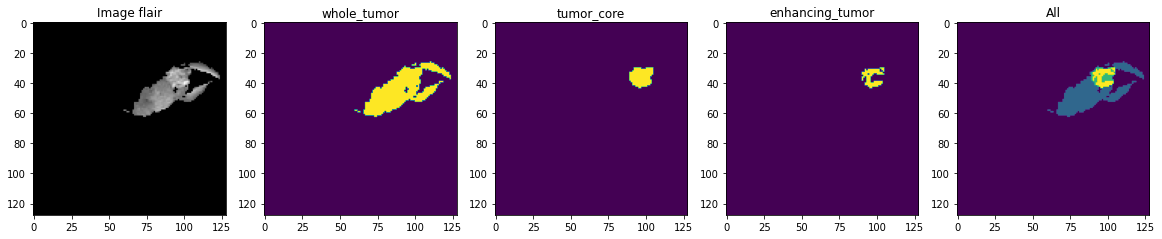

In [84]:
# n_slice=random.randint(0, temp_mask.shape[2])
n_slice = 55
plt.figure(figsize=(20, 10))

plt.subplot(151)
plt.imshow(image[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(152)
plt.imshow(mask[:,:,n_slice,0])
plt.title('whole_tumor')
plt.subplot(153)
plt.imshow(mask[:,:,n_slice, 1])
plt.title('tumor_core')
plt.subplot(154)
plt.imshow(mask[:,:,n_slice,2])
plt.title('enhancing_tumor')
plt.subplot(155)
plt.imshow(np.sum(mask, axis = 3)[:,:,n_slice ])
plt.title('All')
plt.show()